# Inferencia Estadística
## Tarea 1

### Autor:
- [Sergio García Prado](https://garciparedes.me)

In [1]:
rm(list = ls())

In [2]:
library(magrittr)
library(IRdisplay, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(Bhat)
library(ggplot2)
library(reshape2)

In [3]:
options(repr.plot.width=8, repr.plot.height=5)

# Se lanzan seis monedas en cien ocasiones y se anota el número de caras en cada lanzamiento. Los resultados fueron:

In [4]:
coins <- data.frame(hits = c(0, 1, 2, 3, 4, 5, 6),
                    freq = c(2, 8, 10, 12, 16, 30, 22))

In [5]:
coins %>% 
    set_colnames(c('Número de caras', 'Frecuencias')) %>% 
    t() %>% 
    display()

Número de caras,0,1,2,3,4,5,6
Frecuencias,2,8,10,12,16,30,22


## Obtener el $pvalor$ del test de razón de verosimilitud para contrastar la siguiente hipótesis:
$$H_0: \text{Todas las monedas tienen la misma probabilidad de cara}$$

Vamos a definir las siguientes variables aleatorias: 

$$Y_1,..., Y_6 \ iid \quad | \ Y_i \sim Bin(n, p_i)$$

Donde $n = 100$ es el número de realizaciones de la muestra, tal y como se indica en el enunciado y la variable $Y_i$ representa el *número de caras obtenidas por la moneda i-ésima*. Por tanto, el contraste se puede reescribir utilizando esta notación de tal manera que la hipótesis sea:
$$H_0: p_i = p_j \quad \forall i, j \in \{1,..., 6\}$$

Por la propiedad de independencia de las variables $Y_i$ entre si, podemos redefinir dicho test apoyándonos en:

$$X_0 = \sum_{i = 1} ^ 6 Y_i \sim Bin(m, p_0)$$

Donde $m = n * 6 = 600$ y $p_0 = p_i \forall i, \in \{1, ..., 6\}$ Por lo tanto, podemos redefinir el contraste como de bondad de ajuste, donde la hipótesis nula se transforma en:

$$H_0: x \sim X_0$$

Frente a la hipótesis nula de que el vector observado $x$ se distribuye de manera diferente. 

Para contrastar esta hipótesis utilizaremos un *test G (o test $\chi^2$)* basado en la comparación entre frecuencias observadas y esperadas, para lo cual nos apoyaremos en la distribución multinomial.

Para ello, lo primeo es calcular el número de observaciones:

In [6]:
m <- coins %>%
    summarise((max(hits) * sum(freq))) %>%
    pull()

In [7]:
display_latex(paste0('$$m = ', m, '$$'))

Puesto que vamos a realizar el test utilizando frecuencias relativas, es necesario calcular estas sobre los datos observados

In [8]:
coins <- coins %>%
    mutate(freq.rel = freq / sum(freq))

In [9]:
coins %>% 
    set_colnames(c('Número de caras', 'Frecuencias', 'Frecuencias Relativas')) %>% 
    t() %>% 
    round(digits = 3) %>%
    display()

Número de caras,0.00,1.00,2.0,3.00,4.00,5.0,6.00
Frecuencias,2.00,8.00,10.0,12.00,16.00,30.0,22.00
Frecuencias Relativas,0.02,0.08,0.1,0.12,0.16,0.3,0.22


El siguiente paso es obtener el *Estimador Máximo Verosimil* bajo la hipótesis nula:

In [10]:
p.zero.hat <- coins %>%
    mutate(total = freq * hits) %>%
    summarise(sum(total) / m) %>%
    pull()

In [11]:
display_latex(paste0('$$\\hat{p}_0 = ', round(p.zero.hat, digits = 4), '$$'))

Una vez hemos calculado el *EMV* bajo la hipótesis nula, ya podemos calcular el las frecuencias esperadas que deberían seguir nuestras observaciones aproximadamente para poder verificar que todas ellas pertenencen a una misma distribución Binomial con parámetro $p_0$.

In [12]:
coins <- coins %>%
    mutate(expected.freq.rel = dbinom(0:6, n(), p.zero.hat))

In [13]:
coins %>% 
    set_colnames(c('Número de caras', 'Frecuencias', 'Frecuencias Relativas',
                   'Frecuencias Relativas Esperadas')) %>% 
    t() %>% 
    round(digits = 3) %>%
    display()

Número de caras,0.00,1.000,2.000,3.000,4.000,5.000,6.000
Frecuencias,2.00,8.000,10.000,12.000,16.000,30.000,22.000
Frecuencias Relativas,0.02,0.080,0.100,0.120,0.160,0.300,0.220
Frecuencias Relativas Esperadas,0.00,0.005,0.031,0.112,0.242,0.314,0.226


El siguiente paso es obtener el estadístico test G. Este se obtiene a partir del test de razón de verosimilitud de la siguiente forma:

Sea:

$$L(p; x_1,..., x_m) \propto  p ^ {\sum x_i} \cdot (1 - p) ^ {m - \sum x_i}$$

Por lo que:


$$logL(p; x_1,..., x_m) \propto  \sum x_i \cdot log(p) +(m - \sum x_i) \cdot log(1 - p)$$

El estadístico test de razón de verosimilitud se puede escribir por tanto como:

\begin{align*}
  G 
  &=  - 2 \cdot log\left(\Delta(x_1,..., x_m)\right) \\
  &=  - 2 \cdot log\left(\frac{L(\hat{p}_0; x_1,..., x_m)}{L(\hat{p}_{obs}; x_1,..., x_m)}\right) \\
  &=  2 \cdot \left(L(\hat{p}_{obs}; x_1,..., x_m) - L(\hat{p}_{0}; x_1,..., x_m)\right)  \\
  &=  2 \cdot \sum_i y_i \cdot log\left(\frac{\hat{p}_{obs,i}}{\hat{p}_{0,i}}\right) 
\end{align*}

In [14]:
G <- coins %>%
    summarise(2 * sum(freq.rel * log(freq / expected.freq.rel))) %>%
    pull()

In [15]:
display_latex(paste0('$$G = ', round(G, 4), '$$'))

Entonces, para calcular el $pvalor$ del test, basta comparar este estadístico con su distribución bajo $H_0$, en este caso una $\chi^2$ con $7 - 1 = 6$ grados de libertad, ya que el espacio parámetrico de partida es de $7$ valores, mientras que bajo la hipótesis nula, este queda reducido a $1$ único parámetro. Por tanto:

$$pvalor = P(G \geq \chi_6^2)$$

In [16]:
pvalue <- 1 - pchisq(G, df=6)

In [17]:
display_latex(paste0('$$pvalor = ', round(pvalue, 4), '$$'))

Tal y como indica el $pvalor$, a con una confianza del $95\%$ no tenemos indicios suficientes como para rechazar la hipótesis de que todas las observaciones obtenidas provienen todas ellas de una distribución de $6$ monedas, todas ellas distribuidas de la misma forma (igual tasa de acierto).

A continuación se muestra un gráfico de barras que representa de manera conjunta las frecuencias observadas y esperadas:

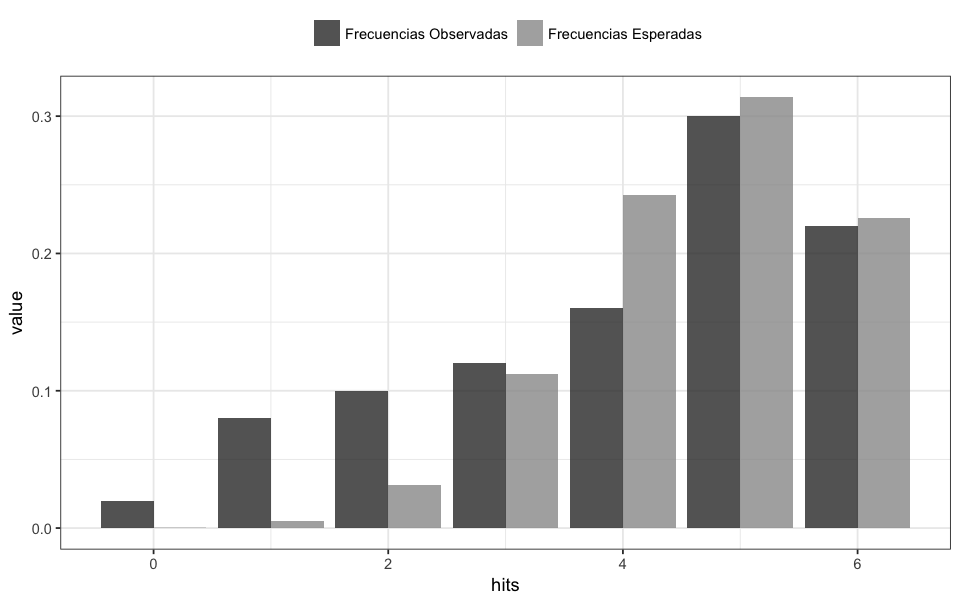

In [18]:
coins %>%
select(hits, freq.rel, expected.freq.rel) %>% 
set_names(c('hits', 'Frecuencias Observadas', 'Frecuencias Esperadas')) %>%
melt(id.vars='hits') %>%
ggplot(aes(x=hits, y=value, fill=variable)) +
    geom_bar(stat='identity', position='dodge', alpha = .8) + 
    scale_fill_manual(values=c("grey20", "grey60")) + 
    theme_bw() +
    theme(legend.position="top", legend.title=element_blank())


## En el modelo que define la hipótesis nula obtener intervalos de confianza ($95\%$) para el parámetro, basados en los estadísticos de *Wald (W)* y de *razón de verosimilitud (VR)*.

In [19]:
alpha <- 0.05

Cálculo por ecuación explícita

In [20]:
W.var <- p.zero.hat * (1 - p.zero.hat) / m
W.IC <- p.zero.hat + c(-1, 1) * qnorm(1 - alpha / 2) * sqrt(W.var)

In [21]:
display_latex(paste0('$$\\left(', round(W.IC[1], 5), ', ', round(W.IC[2], 5) , '\\right)$$'))

Cálculo por optimización numérica

In [22]:
nloglhood <- function(p, n = 600, y = 410) {
    return( -(log(choose(n, y)) + y * log(p) + (n - y) *log(1 - p)) )
}

In [23]:
opt <- optim(0.5, nloglhood,lower = 0.0001,upper = 0.9999, 
             hessian = TRUE, method = "L-BFGS-B")
phat <- opt$par
phat.var <- as.numeric(1 / opt$hessian)

In [24]:
phat + c(-1, 1) * qnorm(1 - alpha / 2) * sqrt(phat.var)

[1] 0.6461118 0.7205537

In [25]:
control.list=list(label="p",est=p.zero.hat,low=0,upp=1)
invisible(capture.output(LR.ci <- plkhci(control.list, nloglhood, "p")))

In [26]:
LR.ci

[1] 0.6453866 0.7197188

# Considerar el vector aleatorio $X = (X_1, ..., X_5)$ 

Supongamos que $X$ se distribuye sobre una distribución multinomial, tal que:

$$X \sim multinomial\left(n, \left(\frac{1}{2}, \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4}\right)\right)$$

Se define el vector aleatorio 

\begin{align*}
  Y 
  &= (Y_1, Y_2, Y_3, Y_4) \\
  &= (X_1 + X_2, X_3, X_4) \\
\end{align*}

Si se observa $y = \left(125, 18, 20, 34\right)$, usar $3$ iteraciones del *algoritmo EM* para aproximar el estimador máximo verosímil de $\theta$, partiendo del valor inicial $\theta^{(0)} = 0.5$.


In [27]:
y <- c(125, 18, 20, 24)
theta.zero <- 0.5
iterations <- 3

In [28]:
p.mapper <- function(theta) {
    c(1 / 2, theta / 4, (1 - theta) / 4, (1 - theta) / 4, theta / 4)
}

In [29]:
minus.likelihood <- function(theta) {
    # TODO 
}

In [30]:
conditional.expectation <- function() {
    # TODO
}

In [31]:
for (itr in 1:iterations) {
    # TODO
}  